In [1]:
import numpy as np,os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from scipy.io import arff
from scipy.stats import spearmanr, pearsonr, linregress
%matplotlib widget

import matplotlib.pyplot as plt, seaborn as sns
from mpl_toolkits.mplot3d import axes3d, Axes3D

from libs import evaluate, read_data

## Imbalance & Noise Ratio
+ IR is very for some datasets. Mean, std:14.96,12.39. Top 3: 34,43,56
+ For noise, Mean, std:15.00,7.28
+ Correlation between these two is statistically significant (r = -.52). So when noise is severe, IR isn't, vice-versa. So we don't have to tackle severe version of both at the same time.  
+ Correlation between IR and size is statistically significant (r = +.62). Again, good news. 

In [2]:
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]

In [3]:
df = pd.DataFrame(columns=['size','IR','noise','#bug_n'],index=DATASETS,dtype='float')
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,stats=False)
    imb = np.unique(y_noisy,return_counts=True)[1]
    df.loc[d,'size'] = len(X)
    df.loc[d,'IR'] = imb.max()/imb.min()
    df.loc[d,'noise'] = (y_noisy!=y_real).sum()/len(X)
    df.loc[d,'#bug_n'] = y_noisy.sum()
df.to_csv("data_info.csv")

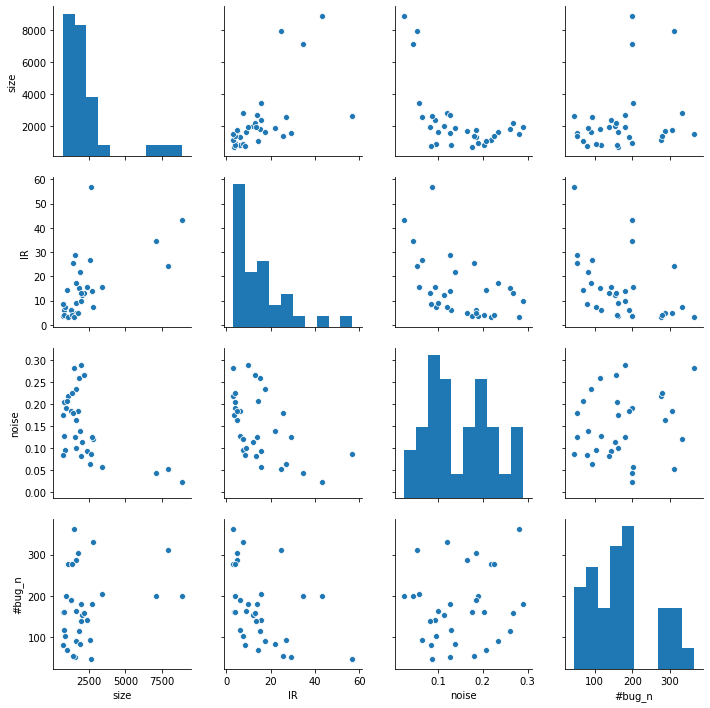

In [4]:
sns.pairplot(df);

In [ ]:
pearsonr(df['IR'],df['size']),spearmanr(df['IR'],df['size']),linregress(df['IR'],df['size'])

## Visualization

In [ ]:
X,y_noisy,y_real = read_data(DATASETS[5],stats=True)

In [ ]:
pca = PCA(n_components=3).fit(X)
Xp = pca.transform(X)
pca.explained_variance_ratio_

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xp[:,0],Xp[:,1],Xp[:,2],c=y_real);

In [ ]:
path = "defect_pred'13/Original/AEEEM/PDE.arff"
df = pd.DataFrame(arff.loadarff(path)[0])
label = 'class'
enc = LabelEncoder().fit(df[label])
df[label] = enc.transform(df[label])
df.shape,np.unique(df.dtypes,return_counts=True),df.isna().sum().sum()

In [ ]:
np.unique(df[label],return_counts=True)

In [ ]:
scaled = pd.DataFrame(StandardScaler().fit_transform(df.drop(columns=[label])))
scaled[label] = df[label]
scaled.shape

In [ ]:
log = pd.DataFrame(np.log1p(df.drop(columns=[label]).values))
log[label] = df[label]

In [ ]:
fig = plt.figure(figsize = (18,20))
ax = fig.gca()
df.hist(ax = ax);

In [ ]:
X = log.drop(columns=[label]).values
Y = df[label].values
X,Y = shuffle(X,Y)

In [ ]:
dt = GridSearchCV(DecisionTreeClassifier(),{'max_leaf_nodes':[10,50,None]},cv=4,iid=False)
rf = RandomForestClassifier(n_estimators=500)
svm = GridSearchCV(SVC(gamma='scale'),{'C':[0.1, 1, 10]},cv=4,iid=False)
knn = GridSearchCV(KNeighborsClassifier(),{'n_neighbors':[3,5,10,20]},cv=4,iid=False)

In [ ]:
cv = RepeatedStratifiedKFold(n_repeats=5,n_splits=10)
res = cross_val_score(knn,X,Y,cv=cv,scoring='f1',n_jobs=-1)
res.mean(),res.std(), res

In [ ]:
a = np.arange(15).reshape(5,3)
a[:,:-2]